In [2]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


In [3]:
from nn_utils import AE_big, AE_3D_200
from utils import plot_activations

In [4]:
torch.cuda.is_available()

False

In [5]:
#fastai.torch_core.defaults.device = 'cuda'

In [6]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')
n_features = len(train.loc[0])

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


In [7]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [8]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [9]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [10]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [11]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fa752cbccf8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fa752c20748>;

Test: None

In [12]:
model = AE_3D_200()

In [13]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()
#loss_func = RMSELoss()
#loss_func = my_loss_func

In [14]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [15]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


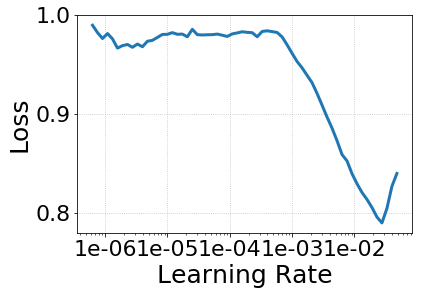

In [16]:
learn.recorder.plot()

In [16]:
lr = 1e-7
learn.fit(1, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.975542,0.976652,02:19


In [17]:
lr = 1e-4
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001390,0.000386,02:17
1,0.000130,0.000125,02:17
2,0.000069,0.000066,02:18
3,0.000362,0.000053,02:18
4,0.000047,0.000066,02:18
5,0.000037,0.000024,02:18
6,0.000040,0.000029,02:18
7,0.000040,0.000074,02:18
8,0.099048,0.000084,02:18
9,0.000038,0.000053,02:18


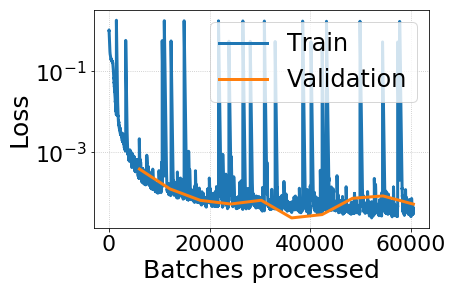

In [18]:
learn.recorder.plot_losses()
plt.yscale('log')

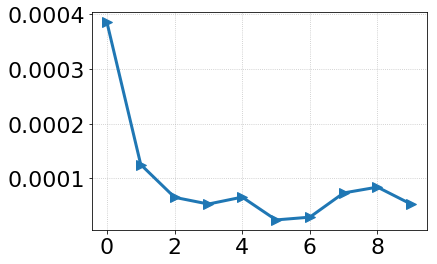

In [19]:
plt.plot(learn.recorder.val_losses, marker='>')

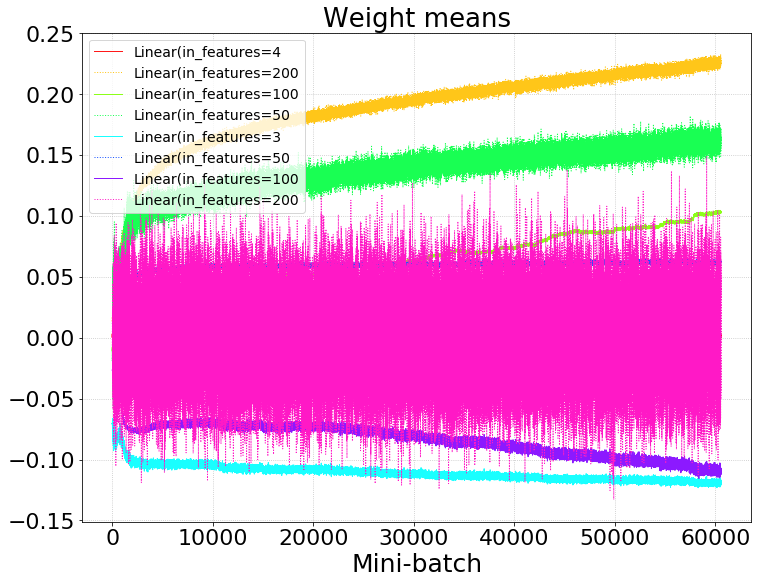

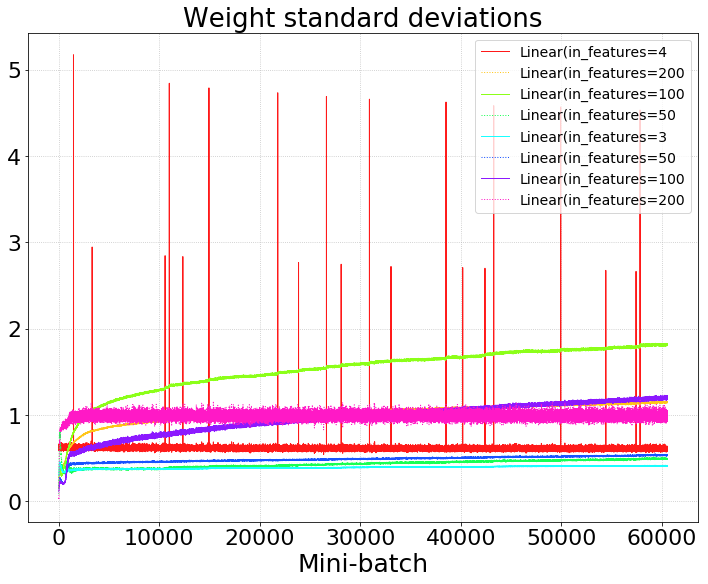

In [21]:
plot_activations(learn)

In [37]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000003,0.000003,01:38
1,0.000003,0.000003,01:44
2,0.007282,0.000003,01:39
3,0.000003,0.000003,01:37
4,0.000004,0.000003,01:40
5,0.000002,0.000003,01:37
6,0.000002,0.000003,01:43
7,0.000002,0.000003,01:48
8,0.000002,0.000003,02:30
9,0.000002,0.000003,01:42


KeyboardInterrupt: 

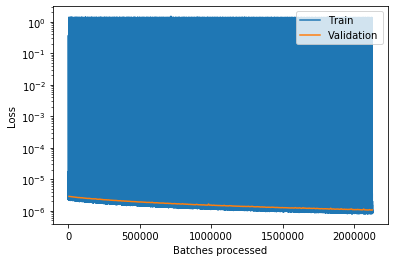

In [39]:
learn.recorder.plot_losses()
plt.yscale('log')

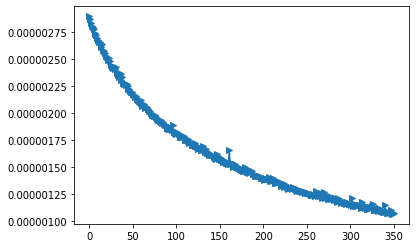

In [42]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [46]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,02:10
1,0.000001,0.000001,01:45
2,0.000001,0.000001,01:43
3,0.000001,0.000001,01:44
4,0.000001,0.000001,01:43
5,0.000055,0.000001,01:43
6,0.000001,0.000001,01:44
7,0.000001,0.000001,01:43
8,0.000001,0.000001,01:44
9,0.000001,0.000001,01:43


KeyboardInterrupt: 

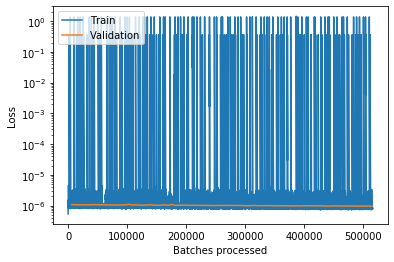

In [47]:
learn.recorder.plot_losses()
plt.yscale('log')

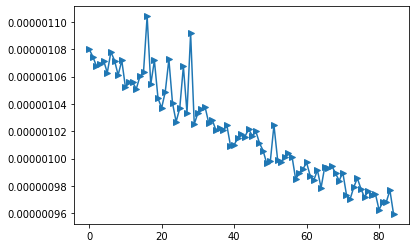

In [48]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [52]:
lr = 3e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,02:01
1,0.000001,0.000001,01:49
2,0.024494,0.000001,01:50
3,0.000001,0.000001,02:16
4,0.000001,0.000001,02:04
5,0.000001,0.000001,01:51
6,0.000009,0.000001,01:54
7,0.000001,0.000001,01:59
8,0.000001,0.000001,02:08
9,0.000001,0.000001,01:58


KeyboardInterrupt: 

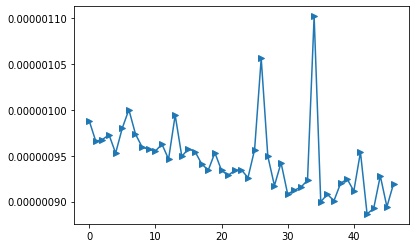

In [53]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [68]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:53
1,0.000001,0.000001,01:49
2,0.000001,0.000001,01:47
3,0.000001,0.000001,01:53
4,0.000001,0.000001,01:55
5,0.000001,0.000001,01:56
6,0.000001,0.000001,01:56
7,0.000002,0.000001,01:46
8,0.000001,0.000001,01:51
9,0.000001,0.000001,01:48


KeyboardInterrupt: 

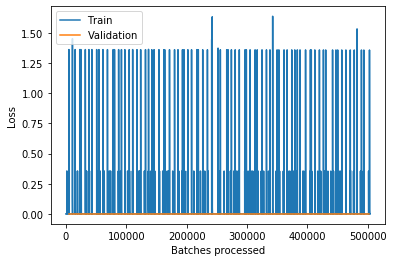

In [70]:
learn.recorder.plot_losses()
#plt.yscale('log')

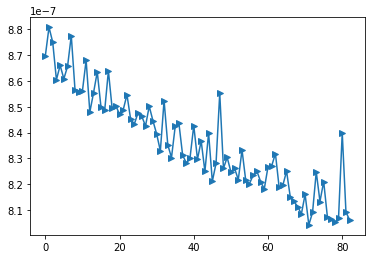

In [71]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [75]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.003669,0.000001,02:02
1,0.000001,0.000001,02:22
2,0.000001,0.000001,02:00
3,0.000001,0.000001,01:56
4,0.000001,0.000001,01:49
5,0.000001,0.000001,01:50
6,0.000001,0.000001,02:06
7,0.000452,0.000001,02:39
8,0.000001,0.000001,02:06
9,0.000001,0.000001,01:58


KeyboardInterrupt: 

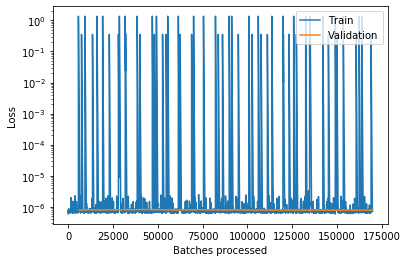

In [77]:
learn.recorder.plot_losses()
plt.yscale('log')

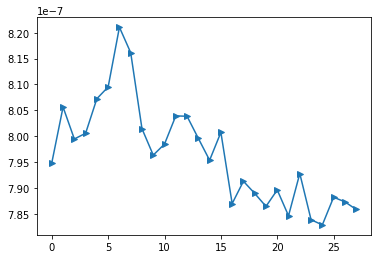

In [78]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [82]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000002,0.000001,01:56
1,0.000001,0.000001,01:52
2,0.000212,0.000001,01:53
3,0.000201,0.000001,01:51
4,0.000001,0.000001,01:52
5,0.000005,0.000001,07:04
6,0.000001,0.000001,08:40
7,0.000065,0.000001,03:27
8,0.000010,0.000001,01:43
9,0.000001,0.000001,01:43


KeyboardInterrupt: 

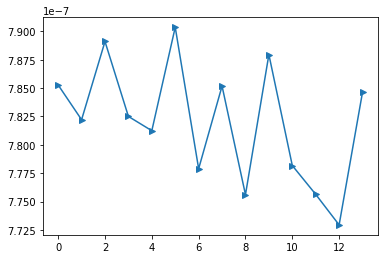

In [83]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [84]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:58
1,0.000001,0.000001,03:56
2,0.000203,0.000001,02:55
3,0.000001,0.000001,02:50
4,0.000001,0.000001,02:51
5,0.000001,0.000001,03:02
6,0.000001,0.000001,02:57
7,0.000001,0.000001,02:50
8,0.000019,0.000001,02:52
9,0.000001,0.000001,02:54


KeyboardInterrupt: 

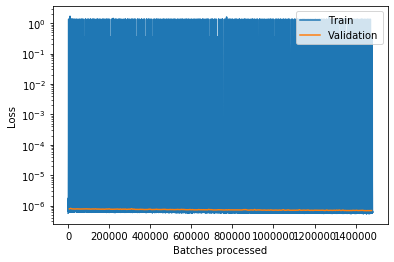

In [86]:
learn.recorder.plot_losses()
plt.yscale('log')

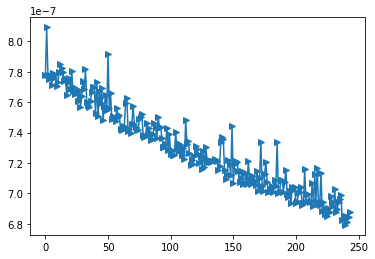

In [87]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [14]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x12af642e8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x12afae080>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent

In [21]:
lr = 3e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000078,0.000001,01:57
1,0.000001,0.000001,01:49


KeyboardInterrupt: 

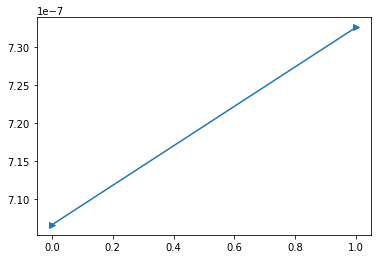

In [22]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [23]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:58
1,0.000001,0.000001,01:43
2,0.000001,0.000001,01:44
3,0.000001,0.000001,01:46
4,0.000001,0.000001,01:42
5,0.000001,0.000001,01:43
6,0.000001,0.000001,01:47
7,0.000001,0.000001,01:52
8,0.000001,0.000001,01:50
9,0.000002,0.000001,01:49


KeyboardInterrupt: 

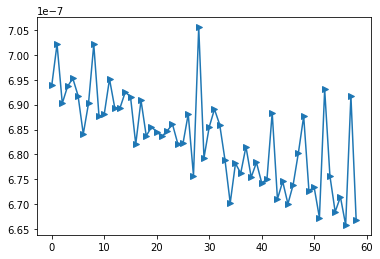

In [24]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [20]:
learn.save('AE_3D_200_no1cycle_trainforever')

In [14]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x1277e2da0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x1277f6748>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent

In [28]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:48
1,0.000001,0.000001,01:43
2,0.000001,0.000001,01:43
3,0.000001,0.000001,01:42
4,0.000001,0.000001,01:46
5,0.000001,0.000001,01:42
6,0.000001,0.000001,01:41
7,0.000001,0.000001,01:43
8,0.000001,0.000001,01:42
9,0.000001,0.000001,01:42


KeyboardInterrupt: 

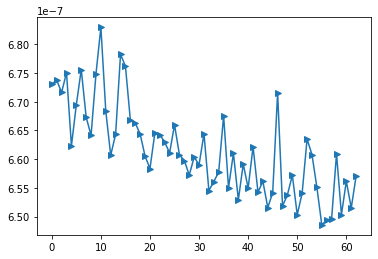

In [29]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [15]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:48
1,0.000001,0.000001,01:44
2,0.000001,0.000001,01:41
3,0.000001,0.000001,01:43
4,0.007245,0.000001,01:42
5,0.000001,0.000001,01:42
6,0.000001,0.000001,01:43
7,0.000001,0.000001,01:42
8,0.000001,0.000001,01:48
9,0.000001,0.000001,01:43


KeyboardInterrupt: 

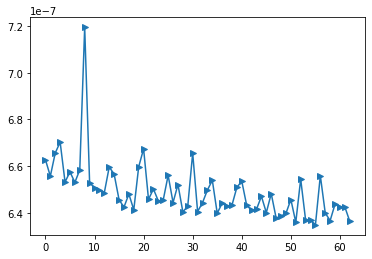

In [16]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [18]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:47
1,0.000001,0.000001,01:43
2,0.000001,0.000001,01:42
3,0.054909,0.000001,01:43
4,0.000260,0.000001,01:42
5,0.000001,0.000001,01:42
6,0.000001,0.000001,01:42
7,0.000001,0.000001,01:43
8,0.000001,0.000001,01:43
9,0.000001,0.000001,01:43


KeyboardInterrupt: 

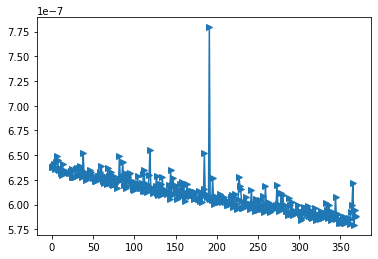

In [19]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [21]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001736,0.000001,01:51
1,0.000001,0.000001,01:44
2,0.000012,0.000001,01:43
3,0.001183,0.000001,01:43
4,0.000001,0.000001,01:42
5,0.000001,0.000001,01:42
6,0.000003,0.000001,01:42
7,0.000001,0.000001,01:43
8,0.000001,0.000001,01:43
9,0.000001,0.000001,01:43


KeyboardInterrupt: 

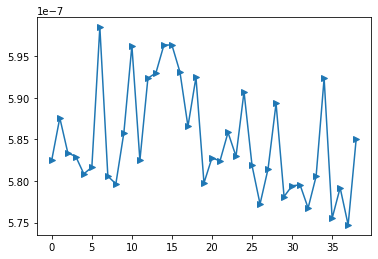

In [22]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [25]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,02:41
1,0.000001,0.000001,02:45


KeyboardInterrupt: 

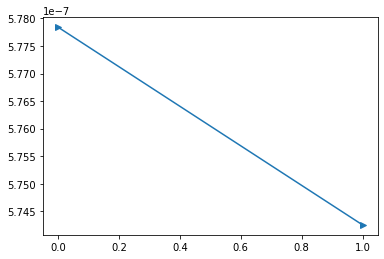

In [26]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [30]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000000,0.000001,01:52
1,0.022094,0.000001,02:11
2,0.000001,0.000001,02:03
3,0.000001,0.000001,02:05
4,0.000001,0.000001,02:31
5,0.000001,0.000001,01:41
6,0.000001,0.000001,01:41
7,0.000001,0.000001,01:43
8,0.000003,0.000001,01:42
9,0.000000,0.000001,01:41


KeyboardInterrupt: 

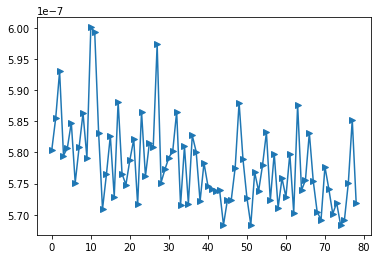

In [31]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [34]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000065,0.000001,01:56
1,0.020313,0.000001,01:44
2,0.000001,0.000001,01:44
3,0.000001,0.000001,01:47
4,0.000001,0.000001,01:46
5,0.000001,0.000001,01:44
6,0.000001,0.000001,01:44
7,0.000001,0.000001,01:45
8,0.000001,0.000001,01:44
9,0.000001,0.000001,01:44


KeyboardInterrupt: 

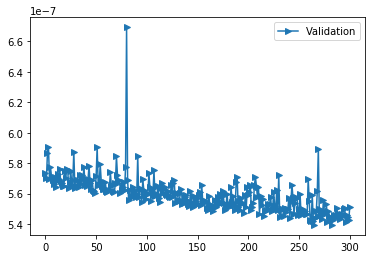

In [39]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [40]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000001,0.000001,01:56
1,0.000000,0.000001,01:43
2,0.000000,0.000001,01:44
3,0.000001,0.000001,01:46
4,0.000001,0.000001,01:43
5,0.000000,0.000001,01:43
6,0.000000,0.000001,01:42
7,0.189249,0.000001,01:43
8,0.000001,0.000001,01:43
9,0.000000,0.000001,01:42


KeyboardInterrupt: 

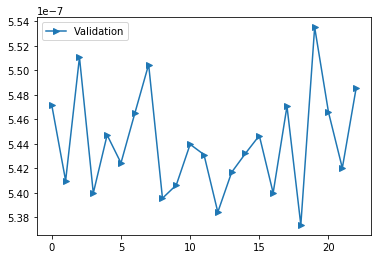

In [41]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [45]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000000,0.000001,07:18
1,0.000001,0.000001,08:02
2,0.000001,0.000001,07:32
3,0.000001,0.000001,07:49
4,0.000001,0.000001,07:13
5,0.000002,0.000001,07:24
6,0.000000,0.000001,07:14
7,0.001927,0.000001,07:27
8,0.000001,0.000001,07:14
9,0.000001,0.000001,07:29


KeyboardInterrupt: 

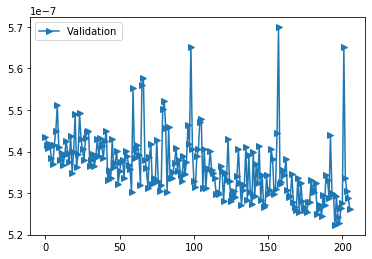

In [46]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [47]:
#learn.save('AE_3D_200_no1cycle_trainforever')

In [17]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fa752cbccf8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fa752c20748>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

In [18]:
learn.validate()

[5.2463446e-07]

In [19]:
curr_save_folder = 'trainforever_plots/'

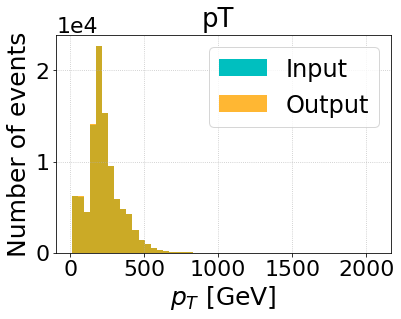

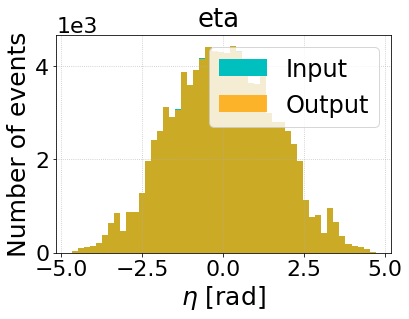

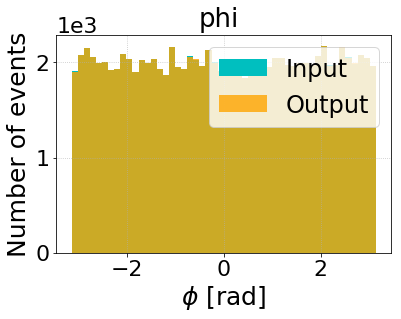

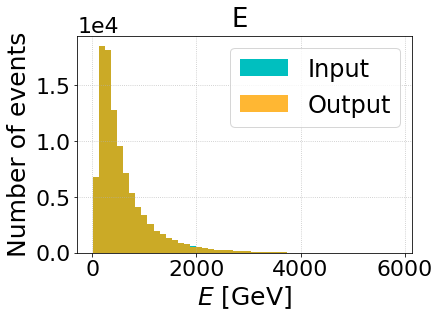

In [20]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

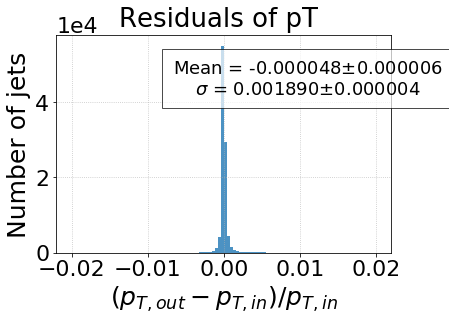

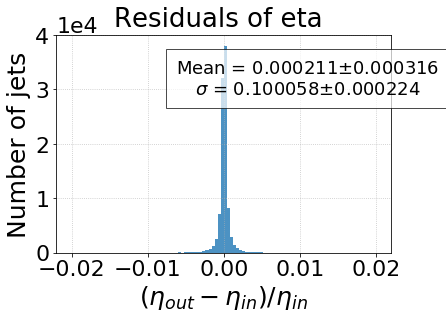

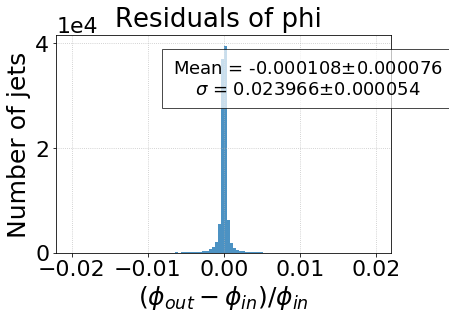

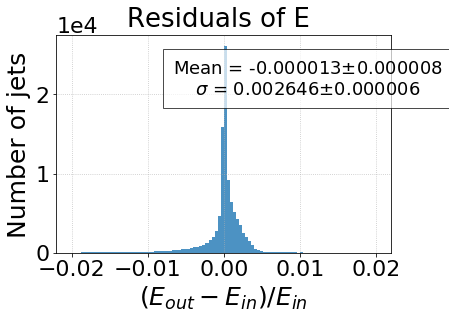

In [21]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [26]:
residuals[:,2].shape

(100000,)

In [27]:
test

,pT,eta,phi,E
1586759,-0.380740,-1.083800,0.689416,-0.109718
355555,-0.276404,0.267833,0.428651,-0.681077
1562615,-0.375840,-1.163177,-1.014827,0.014316
25428,0.991884,-1.495158,-0.814597,2.359694
1291372,-0.398538,-1.000142,-1.042772,-0.229629
...,...,...,...,...
968705,-0.462667,-0.179443,0.117370,-0.734594
1136375,0.023332,-1.109066,0.750207,0.194211
1356104,-0.037530,0.212707,0.092354,-0.636127
484147,-0.726353,0.487041,-1.719046,-0.732523


TypeError: You must first set_array for mappable

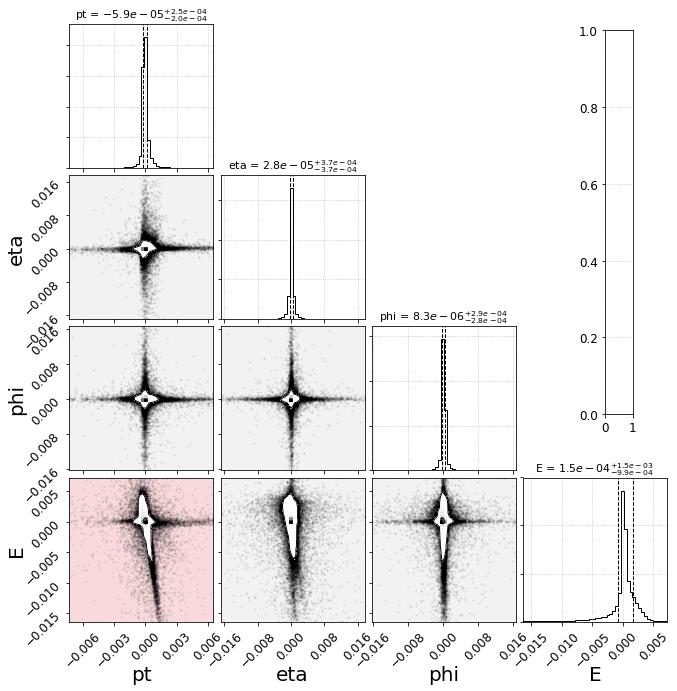

In [22]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)